## 1. Introduction & Project Overview
**Objective:**
The goal of this project is to predict the annual coffee production of the world's top 5 coffee-producing nations (Brazil, Vietnam, Colombia, Indonesia, Ethiopia). Accurate production forecasting is critical for global supply chain optimization and price stability.

**Dataset:**
We utilize the **USDA Production, Supply and Distribution (PSD)** dataset, focusing on the `psd_coffee.csv` file. This dataset provides a comprehensive history of coffee market attributes (Production, Consumption, Trade, Stocks) from 1960 to the present.

**Methodology:**
This project treats the problem as a **Time-Series Regression** task.
- **Evaluation Metric:** Root Mean Squared Error (RMSE) to quantify prediction error in the same units as production (1000 60kg bags).
- **Modeling Strategy:** We benchmark four algorithms (Ridge, Lasso, Random Forest, XGBoost) using a strictly temporal cross-validation strategy (`TimeSeriesSplit`) to prevent data leakage.

In [1]:
# ==========================================
# 1. Library Imports
# ==========================================

# Standard Data Science Stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Machine Learning: Preprocessing & Selection
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Machine Learning: Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning: Models (The 4 Selected Algorithms)
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # The Non-linear Challenger

# Interpretability
from sklearn.inspection import permutation_importance
import shap

# Verify installation of critical packages
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")

Pandas version: 2.3.3
XGBoost version: 3.1.2


In [2]:
# ==========================================
# 2. Global Configuration & Setup
# ==========================================

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# 2.1 Reproducibility
# Setting a global random seed to ensure results are consistent (Rubric requirement)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2.2 Plotting Aesthetics (Rubric: "at least a 300 dpi resolution")
# We set this globally so we don't forget later
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 300,            # High resolution for PDF report
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'lines.linewidth': 2
})
sns.set_theme(style="whitegrid") # Clean, professional look

# 2.3 Directory Structure Enforcement (Rubric Requirement)
# Automatically create the required folders if they don't exist
REQUIRED_DIRS = ['../data', '../figures', '../results', '../src']

for directory in REQUIRED_DIRS:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory exists: {directory}")

print("\nSetup Complete. Environment is ready.")

Directory exists: ../data
Directory exists: ../figures
Directory exists: ../results
Directory exists: ../src

Setup Complete. Environment is ready.


In [3]:
# ==========================================
# 3. Data Loading & Initial Inspection
# ==========================================

# 3.1 Load Data
# We check standard paths to ensure the notebook runs in different environments
data_path = '../data/psd_coffee.csv'
if not os.path.exists(data_path):
    data_path = 'data/psd_coffee.csv' # Fallback
    
df_raw = pd.read_csv(data_path)

# 3.2 Basic Inspection (Replicating previous report's analysis)
# This confirms the dataset structure before manipulation
print("--- Initial Data Inspection (Raw) ---")
print(f"Dataset Shape: {df_raw.shape}")
print("\nData Types:")
print(df_raw.dtypes)
print("\nStatistical Summary (Raw):")
display(df_raw.describe())

# 3.3 Data Engineering: Pivot to Wide Format
# The raw data is in 'Long Format'. For ML, we need 'Wide Format' (One row per Country-Year).
# We assume 'Market_Year' represents the harvest cycle.
df_clean = df_raw[['Country_Name', 'Market_Year', 'Attribute_Description', 'Value']].copy()

df_wide = df_clean.pivot_table(
    index=['Country_Name', 'Market_Year'],
    columns='Attribute_Description',
    values='Value',
    fill_value=0
).reset_index()

# Flatten column names
df_wide.columns.name = None

# 3.4 Filter Top 5 Producers
# We focus on the major players to reduce noise and improve model stability.
top_producers = df_wide.groupby('Country_Name')['Production'].sum().sort_values(ascending=False).head(5).index.tolist()
print(f"\nTop 5 Producers identified: {top_producers}")

df_top5 = df_wide[df_wide['Country_Name'].isin(top_producers)].copy()
df_top5 = df_top5.sort_values(by=['Country_Name', 'Market_Year']).reset_index(drop=True)

print(f"Processed Dataset Shape (Top 5 Only): {df_top5.shape}")
display(df_top5.head())

--- Initial Data Inspection (Raw) ---
Dataset Shape: (85937, 12)

Data Types:
Commodity_Code             int64
Commodity_Description     object
Country_Code              object
Country_Name              object
Market_Year                int64
Calendar_Year              int64
Month                      int64
Attribute_ID               int64
Attribute_Description     object
Unit_ID                    int64
Unit_Description          object
Value                    float64
dtype: object

Statistical Summary (Raw):


,Commodity_Code,Market_Year,Calendar_Year,Month,Attribute_ID,Unit_ID,Value
count,85937.0,85937.000000,85937.000000,85937.000000,85937.000000,85937.0,85937.000000
mean,711100.0,1996.409463,1998.252929,3.865576,90.368421,2.0,829.702899
std,0.0,19.353087,20.795698,4.484462,46.643611,0.0,4118.713029
min,711100.0,1960.000000,1960.000000,0.000000,20.000000,2.0,0.000000
25%,711100.0,1980.000000,1980.000000,0.000000,56.000000,2.0,0.000000
50%,711100.0,2000.000000,2000.000000,0.000000,86.000000,2.0,2.000000
75%,711100.0,2013.000000,2016.000000,6.000000,125.000000,2.0,220.000000
max,711100.0,2025.000000,2025.000000,12.000000,178.000000,2.0,97806.000000



Top 5 Producers identified: ['Brazil', 'Colombia', 'Vietnam', 'Indonesia', 'Ethiopia']
Processed Dataset Shape (Top 5 Only): (330, 21)


,Country_Name,Market_Year,Arabica Production,Bean Exports,Bean Imports,Beginning Stocks,Domestic Consumption,Ending Stocks,Exports,Imports,...,Production,Roast & Ground Exports,Roast & Ground Imports,Robusta Production,"Rst,Ground Dom. Consum",Soluble Dom. Cons.,Soluble Exports,Soluble Imports,Total Distribution,Total Supply
0,Brazil,1960,29800.0,16110.0,0.0,53520.0,9001.0,58206.0,16113.0,0.0,...,29800.0,3.0,0.0,0.0,8976.0,25.0,0.0,0.0,83320.0,83320.0
1,Brazil,1961,39600.0,17410.0,0.0,58206.0,13220.0,67174.0,17412.0,0.0,...,39600.0,1.0,0.0,0.0,13190.0,30.0,1.0,0.0,97806.0,97806.0
2,Brazil,1962,28900.0,16864.0,0.0,67174.0,6741.0,72461.0,16872.0,0.0,...,28900.0,7.0,0.0,0.0,6706.0,35.0,1.0,0.0,96074.0,96074.0
3,Brazil,1963,23200.0,18860.0,0.0,72461.0,9520.0,67272.0,18869.0,0.0,...,23200.0,7.0,0.0,0.0,9480.0,40.0,2.0,0.0,95661.0,95661.0
4,Brazil,1964,11000.0,12409.0,0.0,67272.0,8131.0,57723.0,12418.0,0.0,...,11000.0,1.0,0.0,0.0,8086.0,45.0,8.0,0.0,78272.0,78272.0


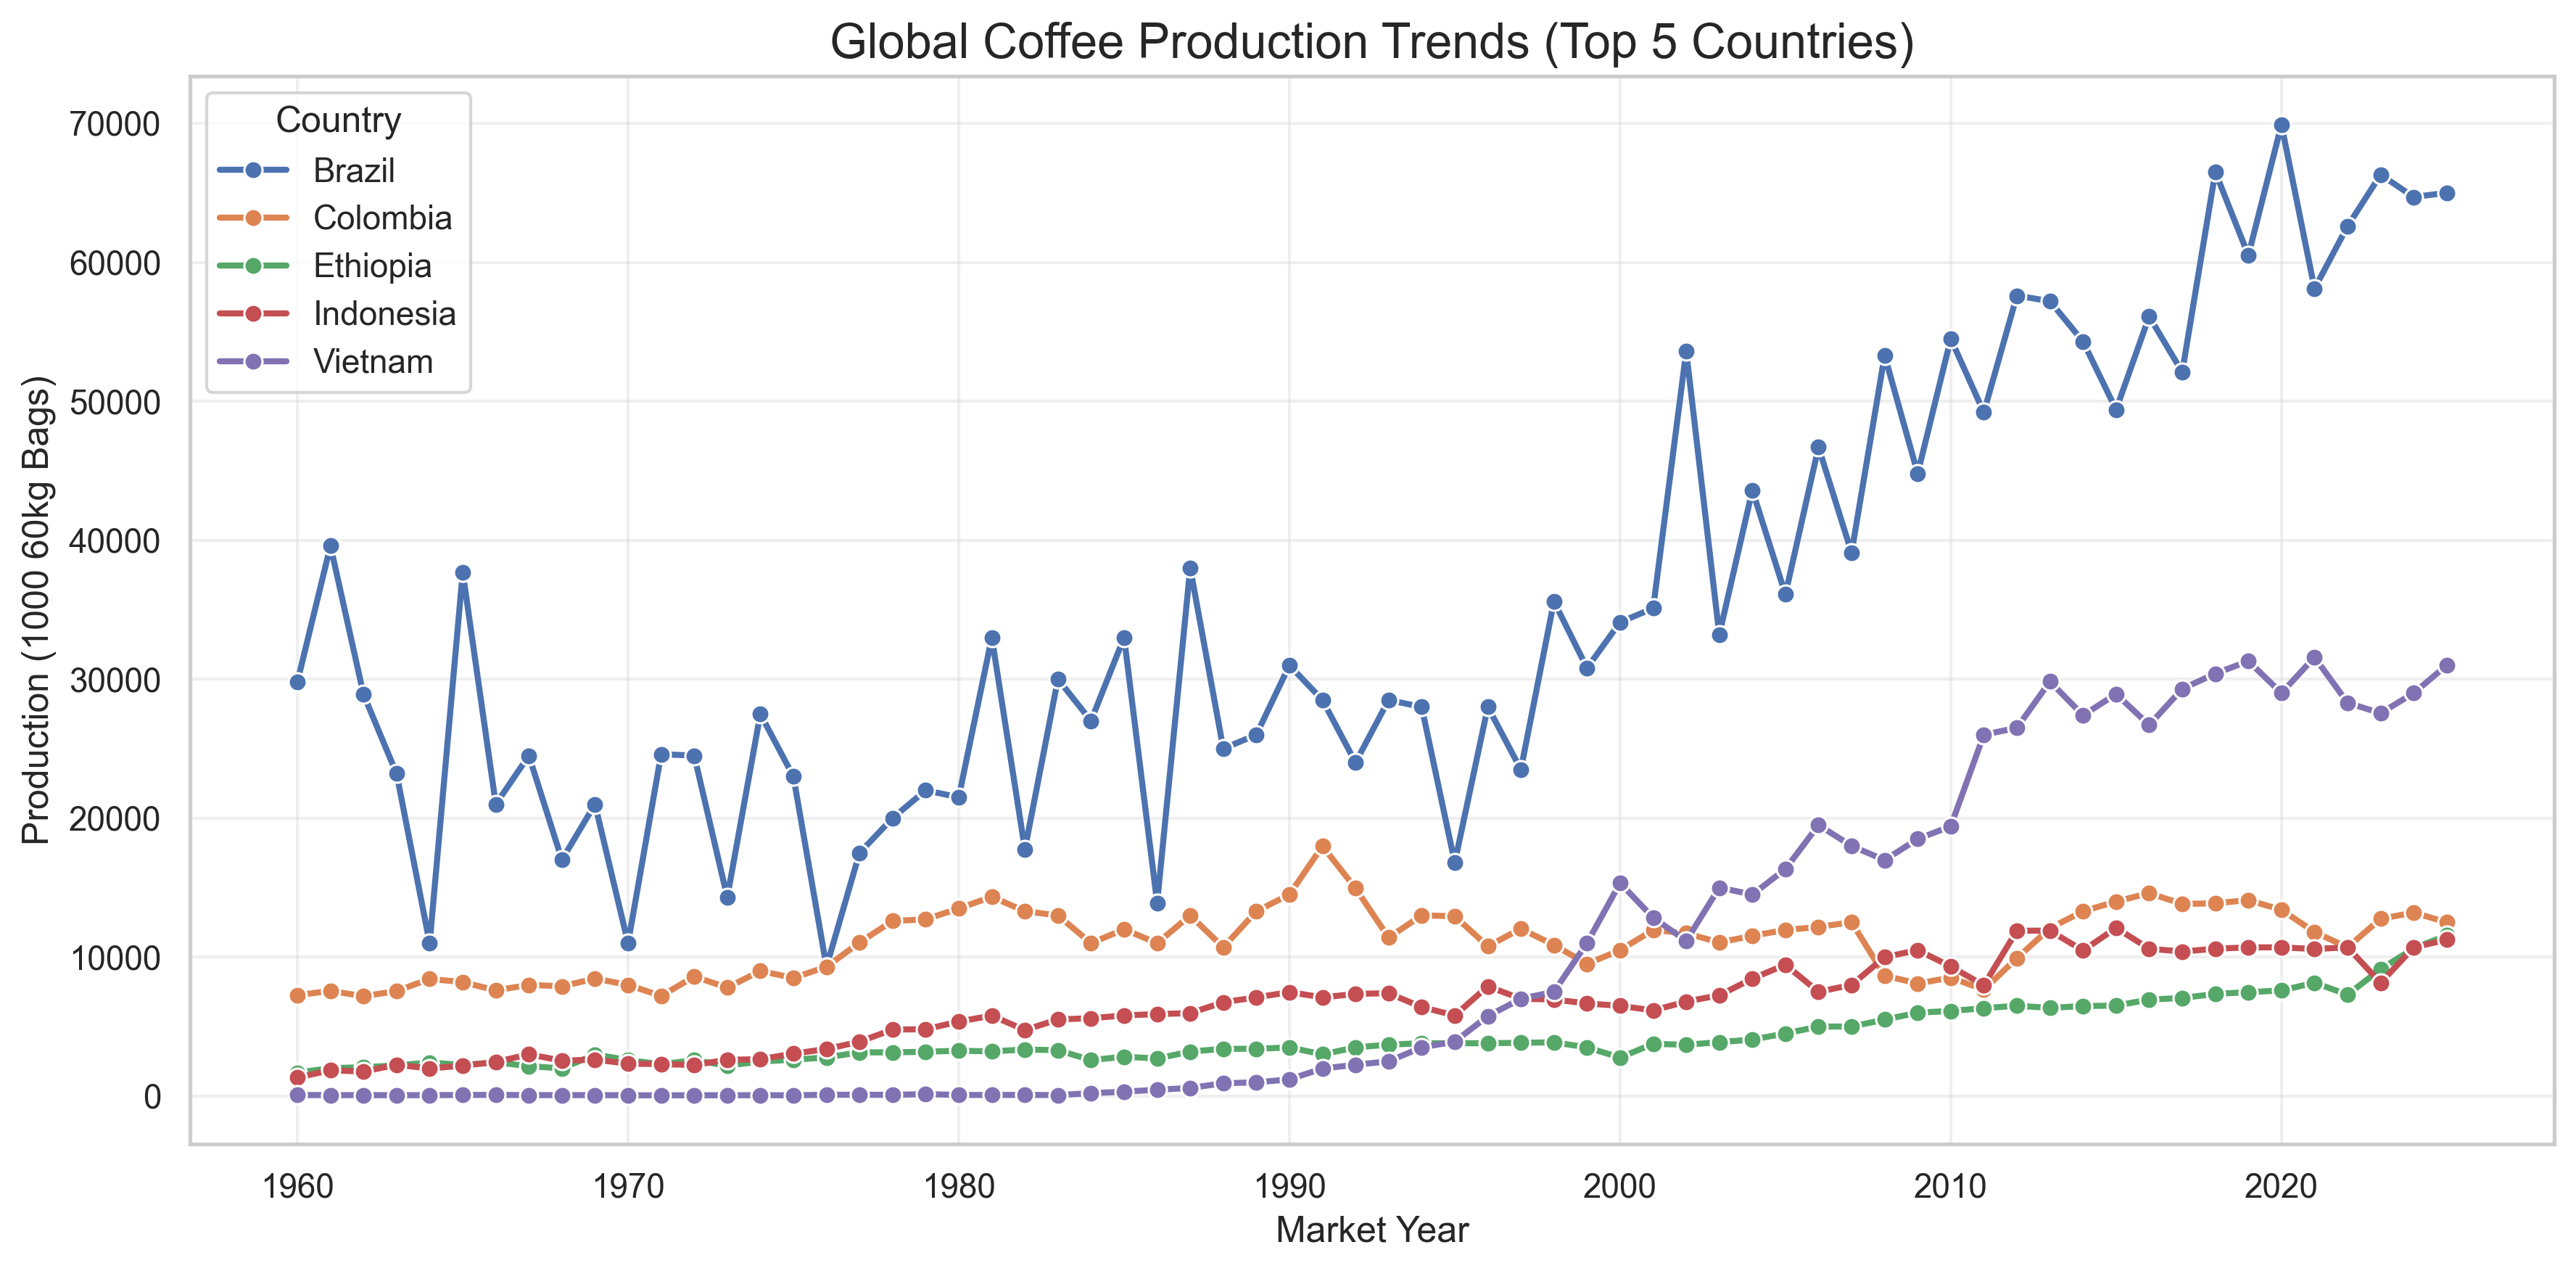

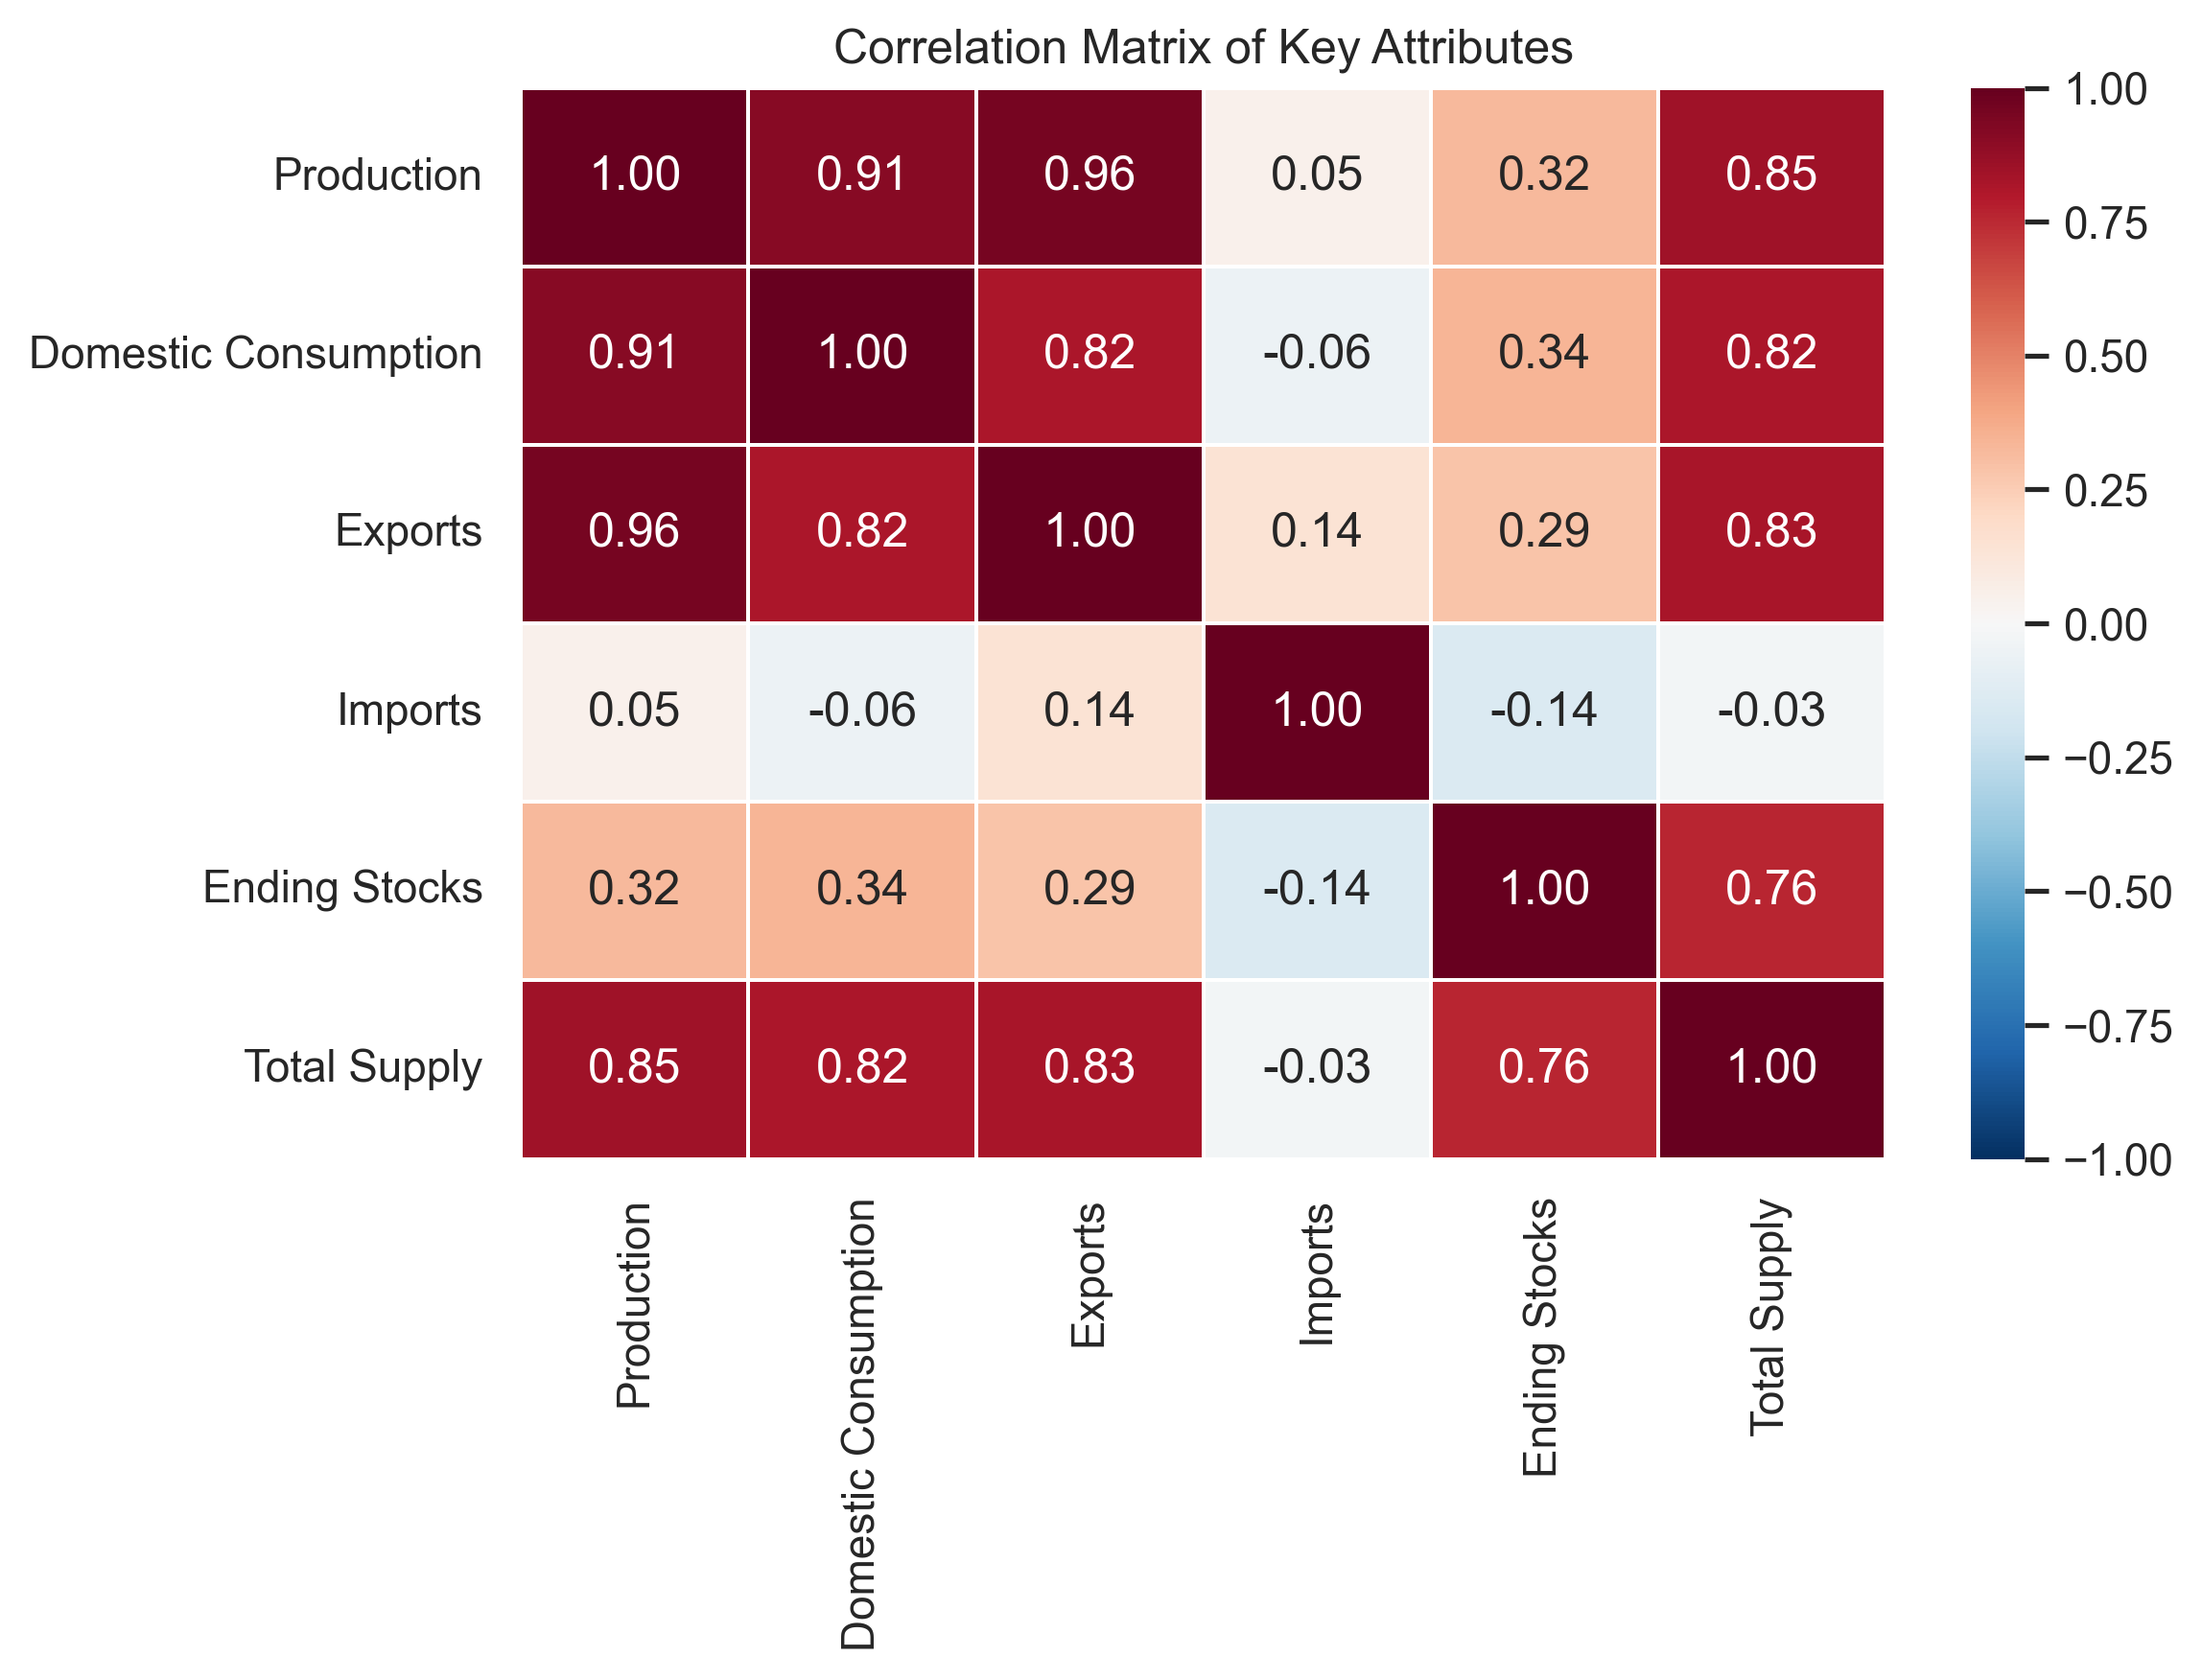

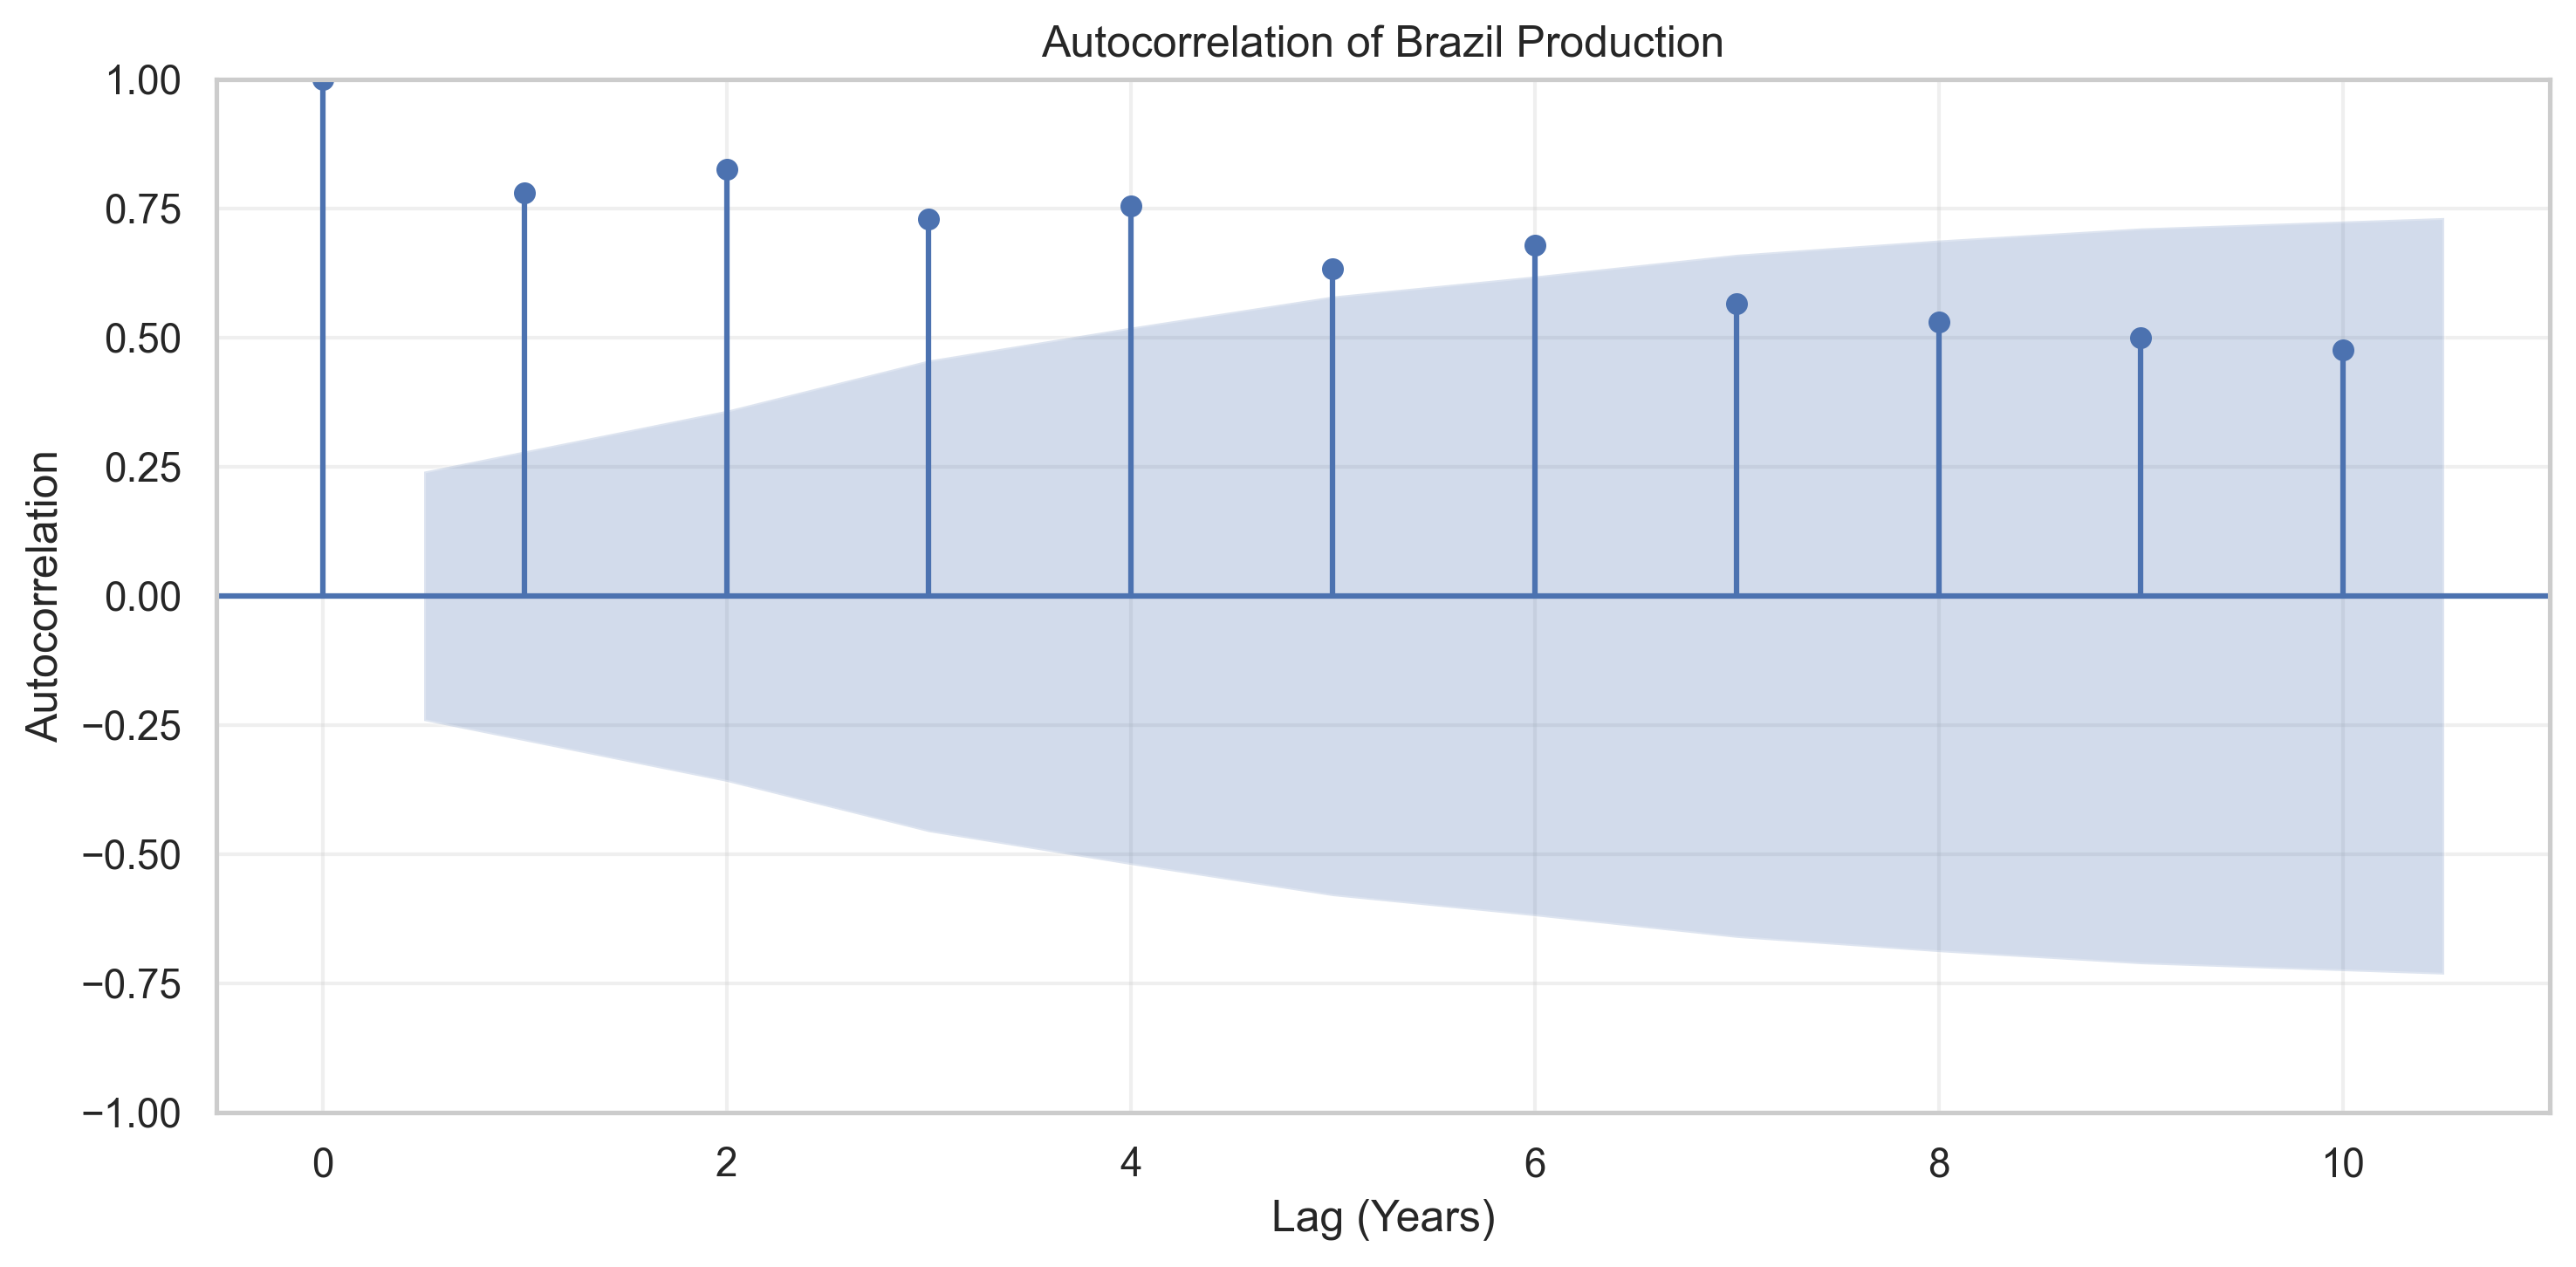

EDA Figures saved successfully to ../figures/


In [5]:
# ==========================================
# 4. Exploratory Data Analysis (EDA)
# ==========================================

# 4.1 Production Trends (Time Series View)
# Goal: Highlight the seasonality (especially Brazil's biennial cycle) and long-term trends.
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top5, x='Market_Year', y='Production', hue='Country_Name', marker='o', linewidth=2)
plt.title('Global Coffee Production Trends (Top 5 Countries)', fontsize=16)
plt.ylabel('Production (1000 60kg Bags)')
plt.xlabel('Market Year')
plt.legend(title='Country', loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# Saving figure for the report (Rubric requirement: 300 dpi)
plt.savefig('../figures/production_trends.png')
plt.show()

# 4.2 Correlation Analysis
# Goal: Check relationships between attributes (e.g., Does high stock lead to low production?)
key_features = ['Production', 'Domestic Consumption', 'Exports', 'Imports', 'Ending Stocks', 'Total Supply']
corr_matrix = df_top5[key_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Attributes')
plt.tight_layout()
plt.savefig('../figures/correlation_heatmap.png')
plt.show()

# 4.3 Autocorrelation Analysis (The Scientific Justification)
# Goal: Prove that "Past Production" predicts "Future Production" (Justifying Lag Features).
# We focus on Brazil as it has the strongest signal.
from statsmodels.graphics.tsaplots import plot_acf

brazil_prod = df_top5[df_top5['Country_Name'] == 'Brazil']['Production']

plt.figure(figsize=(10, 5))
# Lags=10 years is sufficient to show the cycle
plot_acf(brazil_prod, lags=10, title='Autocorrelation of Brazil Production', ax=plt.gca())
plt.xlabel('Lag (Years)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/autocorrelation_brazil.png')
plt.show()

print("EDA Figures saved successfully to ../figures/")

In [6]:
# ==========================================
# 5. Feature Engineering (Methods Section)
# ==========================================

print("--- Starting Feature Engineering ---")
# Create a copy to avoid SettingWithCopy warnings
df_eng = df_top5.copy()

# 5.1 Domain Knowledge Feature: Stock-to-Use Ratio (STU)
# Logic: (Ending Stocks) / (Domestic Consumption + Exports)
# This measures supply tightness. Low STU -> High Price -> Higher Future Production.
# Note: We calculate it for year 't', but we MUST lag it later to predict 't+1'.
df_eng['Total_Use'] = df_eng['Domestic Consumption'] + df_eng['Exports']
# Handle division by zero
df_eng['STU_Ratio'] = df_eng.apply(
    lambda row: row['Ending Stocks'] / row['Total_Use'] if row['Total_Use'] > 0 else 0, 
    axis=1
)

print("Created Domain Feature: Stock-to-Use (STU) Ratio")

# 5.2 Lag Feature Generation (The Critical Fix for Time Series)
# Rubric: "Describe data preprocessing... considerations went into each step"
# Explanation: We cannot use Year t's Stocks to predict Year t's Production (Leakage).
# We must use Year t-1, t-2, t-3 data to predict Year t.

target = 'Production'
# Features we want to use as predictors (History of...)
features_to_lag = ['Production', 'Domestic Consumption', 'Exports', 'Imports', 'Ending Stocks', 'STU_Ratio']
lags = [1, 2, 3] # Using history from 1, 2, and 3 years ago

print(f"Generating Lag Features for: {features_to_lag}")

for country in df_eng['Country_Name'].unique():
    # We must group by country so lags don't spill over from Brazil to Vietnam
    country_idx = df_eng['Country_Name'] == country
    
    for feature in features_to_lag:
        for lag in lags:
            col_name = f"{feature}_Lag{lag}"
            # Shift the data downwards
            df_eng.loc[country_idx, col_name] = df_eng.loc[country_idx, feature].shift(lag)

# 5.3 Handling Missing Values (Lecture 18/19)
# Lagging creates NaNs in the first few years (e.g., 1960 has no 1959 data).
# Since we have data from 1960-2024, dropping the first 3 years is statistically safer than imputation.
before_drop = df_eng.shape[0]
df_final = df_eng.dropna().reset_index(drop=True)
dropped_rows = before_drop - df_final.shape[0]

print(f"\nDropped {dropped_rows} rows due to Lag creation (first 3 years of each country).")
print(f"Final Processed Data Shape: {df_final.shape}")

# 5.4 Define Predictors (X) and Target (y)
# CRITICAL: We only use columns with '_Lag' in their name for X.
# This guarantees no data leakage.
feature_cols = [c for c in df_final.columns if '_Lag' in c]
X = df_final[feature_cols]
y = df_final[target]
groups = df_final['Country_Name'] # Useful if we want to do GroupKFold later

print(f"\nPredictor Features (X): {len(feature_cols)} features")
print(feature_cols[:5], "...") # Show first 5 features

# Check for leakage: Ensure no current-year columns are in X
assert 'Production' not in X.columns
assert 'STU_Ratio' not in X.columns
print("Data Leakage Check: PASSED")

df_final.head()

--- Starting Feature Engineering ---
Created Domain Feature: Stock-to-Use (STU) Ratio
Generating Lag Features for: ['Production', 'Domestic Consumption', 'Exports', 'Imports', 'Ending Stocks', 'STU_Ratio']

Dropped 15 rows due to Lag creation (first 3 years of each country).
Final Processed Data Shape: (315, 41)

Predictor Features (X): 18 features
['Production_Lag1', 'Production_Lag2', 'Production_Lag3', 'Domestic Consumption_Lag1', 'Domestic Consumption_Lag2'] ...
Data Leakage Check: PASSED


,Country_Name,Market_Year,Arabica Production,Bean Exports,Bean Imports,Beginning Stocks,Domestic Consumption,Ending Stocks,Exports,Imports,...,Exports_Lag3,Imports_Lag1,Imports_Lag2,Imports_Lag3,Ending Stocks_Lag1,Ending Stocks_Lag2,Ending Stocks_Lag3,STU_Ratio_Lag1,STU_Ratio_Lag2,STU_Ratio_Lag3
0,Brazil,1963,23200.0,18860.0,0.0,72461.0,9520.0,67272.0,18869.0,0.0,...,16113.0,0.0,0.0,0.0,72461.0,67174.0,58206.0,3.068691,2.192935,2.317671
1,Brazil,1964,11000.0,12409.0,0.0,67272.0,8131.0,57723.0,12418.0,0.0,...,17412.0,0.0,0.0,0.0,67272.0,72461.0,67174.0,2.369650,3.068691,2.192935
2,Brazil,1965,37700.0,16411.0,0.0,57723.0,8100.0,70802.0,16521.0,0.0,...,16872.0,0.0,0.0,0.0,57723.0,67272.0,72461.0,2.809042,2.369650,3.068691
3,Brazil,1966,21000.0,16023.0,0.0,70802.0,8620.0,66761.0,16421.0,0.0,...,18869.0,0.0,0.0,0.0,70802.0,57723.0,67272.0,2.875675,2.809042,2.369650
4,Brazil,1967,24500.0,18347.0,0.0,66761.0,8750.0,63547.0,18964.0,0.0,...,12418.0,0.0,0.0,0.0,66761.0,70802.0,57723.0,2.666068,2.875675,2.809042


In [8]:
# ==========================================
# 6. Model Training, Evaluation & Baseline Comparison
# ==========================================
# Rubric Requirements Covered:
# 1. Compare to baseline score.
# 2. Measure uncertainties (Std Dev).
# 3. "How many standard deviations above baseline".
# 4. Benchmarking 4 algorithms (2 linear, 2 non-linear).

from sklearn.dummy import DummyRegressor

print("--- Starting Advanced Model Evaluation ---")

# 6.1 Setup Time Series Split
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# 6.2 Step 1: Establish the "Naive" Baseline
# Rubric: "Discuss how your scores compare to a baseline score"
# We use a Dummy Regressor that always predicts the mean of the training set.
print("Training Baseline Model (DummyRegressor)...")
dummy_model = DummyRegressor(strategy='mean')
dummy_scores = []

# Manually run CV for Dummy to get Std Dev
for train_idx, test_idx in tscv.split(X, y):
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[test_idx], y.iloc[test_idx]
    
    dummy_model.fit(X_train_fold, y_train_fold)
    y_pred_dummy = dummy_model.predict(X_test_fold)
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_dummy))
    dummy_scores.append(rmse)

baseline_mean = np.mean(dummy_scores)
baseline_std = np.std(dummy_scores)
print(f"Baseline RMSE: {baseline_mean:.2f} (+/- {baseline_std:.2f})")


# 6.3 Step 2: Define ML Models
model_configs = {
    'Ridge (Linear)': {
        'model': Ridge(random_state=RANDOM_STATE),
        'params': {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso (Linear)': {
        'model': Lasso(random_state=RANDOM_STATE, max_iter=10000),
        'params': {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'RandomForest (Non-linear)': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {'model__n_estimators': [100], 'model__max_depth': [10, 20]}
    },
    'XGBoost (Non-linear)': {
        'model': xgb.XGBRegressor(random_state=RANDOM_STATE, objective='reg:squarederror'),
        'params': {'model__n_estimators': [100], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]}
    }
}

# 6.4 Step 3: Train & Benchmark ML Models
results_list = []
trained_models = {} # Store models for Feature Importance extraction

for name, config in model_configs.items():
    print(f"\nTraining {name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', config['model'])
    ])
    
    grid = GridSearchCV(
        pipeline, config['params'], cv=tscv, 
        scoring='neg_root_mean_squared_error', n_jobs=-1
    )
    grid.fit(X, y)
    
    # Metrics
    rmse_mean = -grid.best_score_
    best_idx = grid.best_index_
    rmse_std = grid.cv_results_['std_test_score'][best_idx]
    
    # Rubric: "How many standard deviations above the baseline your model is"
    # Calculation: (Baseline_Mean - Model_Mean) / Model_Std
    # Interpretation: "How significant is the improvement given the model's instability?"
    improvement = baseline_mean - rmse_mean
    z_score_improvement = improvement / rmse_std if rmse_std > 0 else 0
    
    print(f"  Best RMSE: {rmse_mean:.2f} (Std: {rmse_std:.2f})")
    print(f"  Improvement vs Baseline: {improvement:.2f} (Z-Score: {z_score_improvement:.2f})")
    
    results_list.append({
        'Model': name,
        'RMSE Mean': rmse_mean,
        'RMSE Std': rmse_std,
        'Baseline RMSE': baseline_mean,
        'Improvement (Raw)': improvement,
        'Std Devs above Baseline': z_score_improvement, # The specific Rubric metric
        'Best Params': str(grid.best_params_)
    })
    
    trained_models[name] = grid.best_estimator_

# 6.5 Output Summary Table
results_df = pd.DataFrame(results_list).sort_values(by='RMSE Mean')
results_df.to_csv('../results/model_comparison.csv', index=False)

print("\n--- Final Performance Summary (Rubric Results Table) ---")
display(results_df[['Model', 'RMSE Mean', 'RMSE Std', 'Improvement (Raw)', 'Std Devs above Baseline']])


# ==========================================
# 6.6 Extracting 3 Types of Global Feature Importance (Rubric Requirement)
# ==========================================
print("\n--- Calculating 3 Global Feature Importances ---")

# Type 1: Linear Coefficients (from Ridge)
# Why: Shows directionality (+/- impact)
ridge_model = trained_models['Ridge (Linear)'].named_steps['model']
ridge_coefs = pd.Series(ridge_model.coef_, index=X.columns).sort_values(key=abs, ascending=False).head(5)
print("\n1. Linear Coefficients (Ridge - Directional Importance):")
print(ridge_coefs)

# Type 2: MDI / Gini Importance (from Random Forest)
# Why: Shows which features structurally reduce variance the most
rf_model = trained_models['RandomForest (Non-linear)'].named_steps['model']
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(5)
print("\n2. MDI Feature Importance (Random Forest - Structural Importance):")
print(rf_importances)

# Type 3: Permutation Importance (from XGBoost)
# Why: Model-agnostic, measures impact on prediction error (RMSE) when feature is shuffled
# Note: We calculate this on the *whole* dataset for global interpretation context
xgb_pipe = trained_models['XGBoost (Non-linear)']
perm_result = permutation_importance(xgb_pipe, X, y, n_repeats=5, random_state=RANDOM_STATE)
perm_importances = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False).head(5)
print("\n3. Permutation Importance (XGBoost - Predictive Power):")
print(perm_importances)

print("\nAll metrics calculated. Ready for visualization (Cell 8).")

--- Starting Advanced Model Evaluation ---
Training Baseline Model (DummyRegressor)...
Baseline RMSE: 15825.22 (+/- 4933.40)

Training Ridge (Linear)...
  Best RMSE: 3999.24 (Std: 3049.32)
  Improvement vs Baseline: 11825.98 (Z-Score: 3.88)

Training Lasso (Linear)...
  Best RMSE: 4138.65 (Std: 2936.25)
  Improvement vs Baseline: 11686.57 (Z-Score: 3.98)

Training RandomForest (Non-linear)...
  Best RMSE: 4808.60 (Std: 4508.74)
  Improvement vs Baseline: 11016.62 (Z-Score: 2.44)

Training XGBoost (Non-linear)...
  Best RMSE: 4712.75 (Std: 3826.98)
  Improvement vs Baseline: 11112.47 (Z-Score: 2.90)

--- Final Performance Summary (Rubric Results Table) ---


,Model,RMSE Mean,RMSE Std,Improvement (Raw),Std Devs above Baseline
0,Ridge (Linear),3999.241964,3049.317098,11825.975758,3.878237
1,Lasso (Linear),4138.648293,2936.253249,11686.569428,3.980096
3,XGBoost (Non-linear),4712.747601,3826.983349,11112.470121,2.903715
2,RandomForest (Non-linear),4808.602056,4508.736291,11016.615666,2.443393



--- Calculating 3 Global Feature Importances ---

1. Linear Coefficients (Ridge - Directional Importance):
Production_Lag2              3130.884139
Exports_Lag3                 2482.972040
Exports_Lag1                 2328.120156
Exports_Lag2                 2266.620050
Domestic Consumption_Lag1    2077.479010
dtype: float64

2. MDI Feature Importance (Random Forest - Structural Importance):
Production_Lag2              0.271472
Production_Lag3              0.180482
Domestic Consumption_Lag1    0.138360
Production_Lag1              0.115419
Exports_Lag1                 0.084555
dtype: float64

3. Permutation Importance (XGBoost - Predictive Power):
Production_Lag2              0.122202
Production_Lag1              0.118464
Domestic Consumption_Lag1    0.099585
Production_Lag3              0.088631
Domestic Consumption_Lag2    0.034629
dtype: float64

All metrics calculated. Ready for visualization (Cell 8).


--- Phase 7: Final Visualization & Interpretation ---
Retraining XGBoost (Non-linear) on first 80% of data...
Saved Prediction Plot to: ../figures/prediction_vs_actual.png


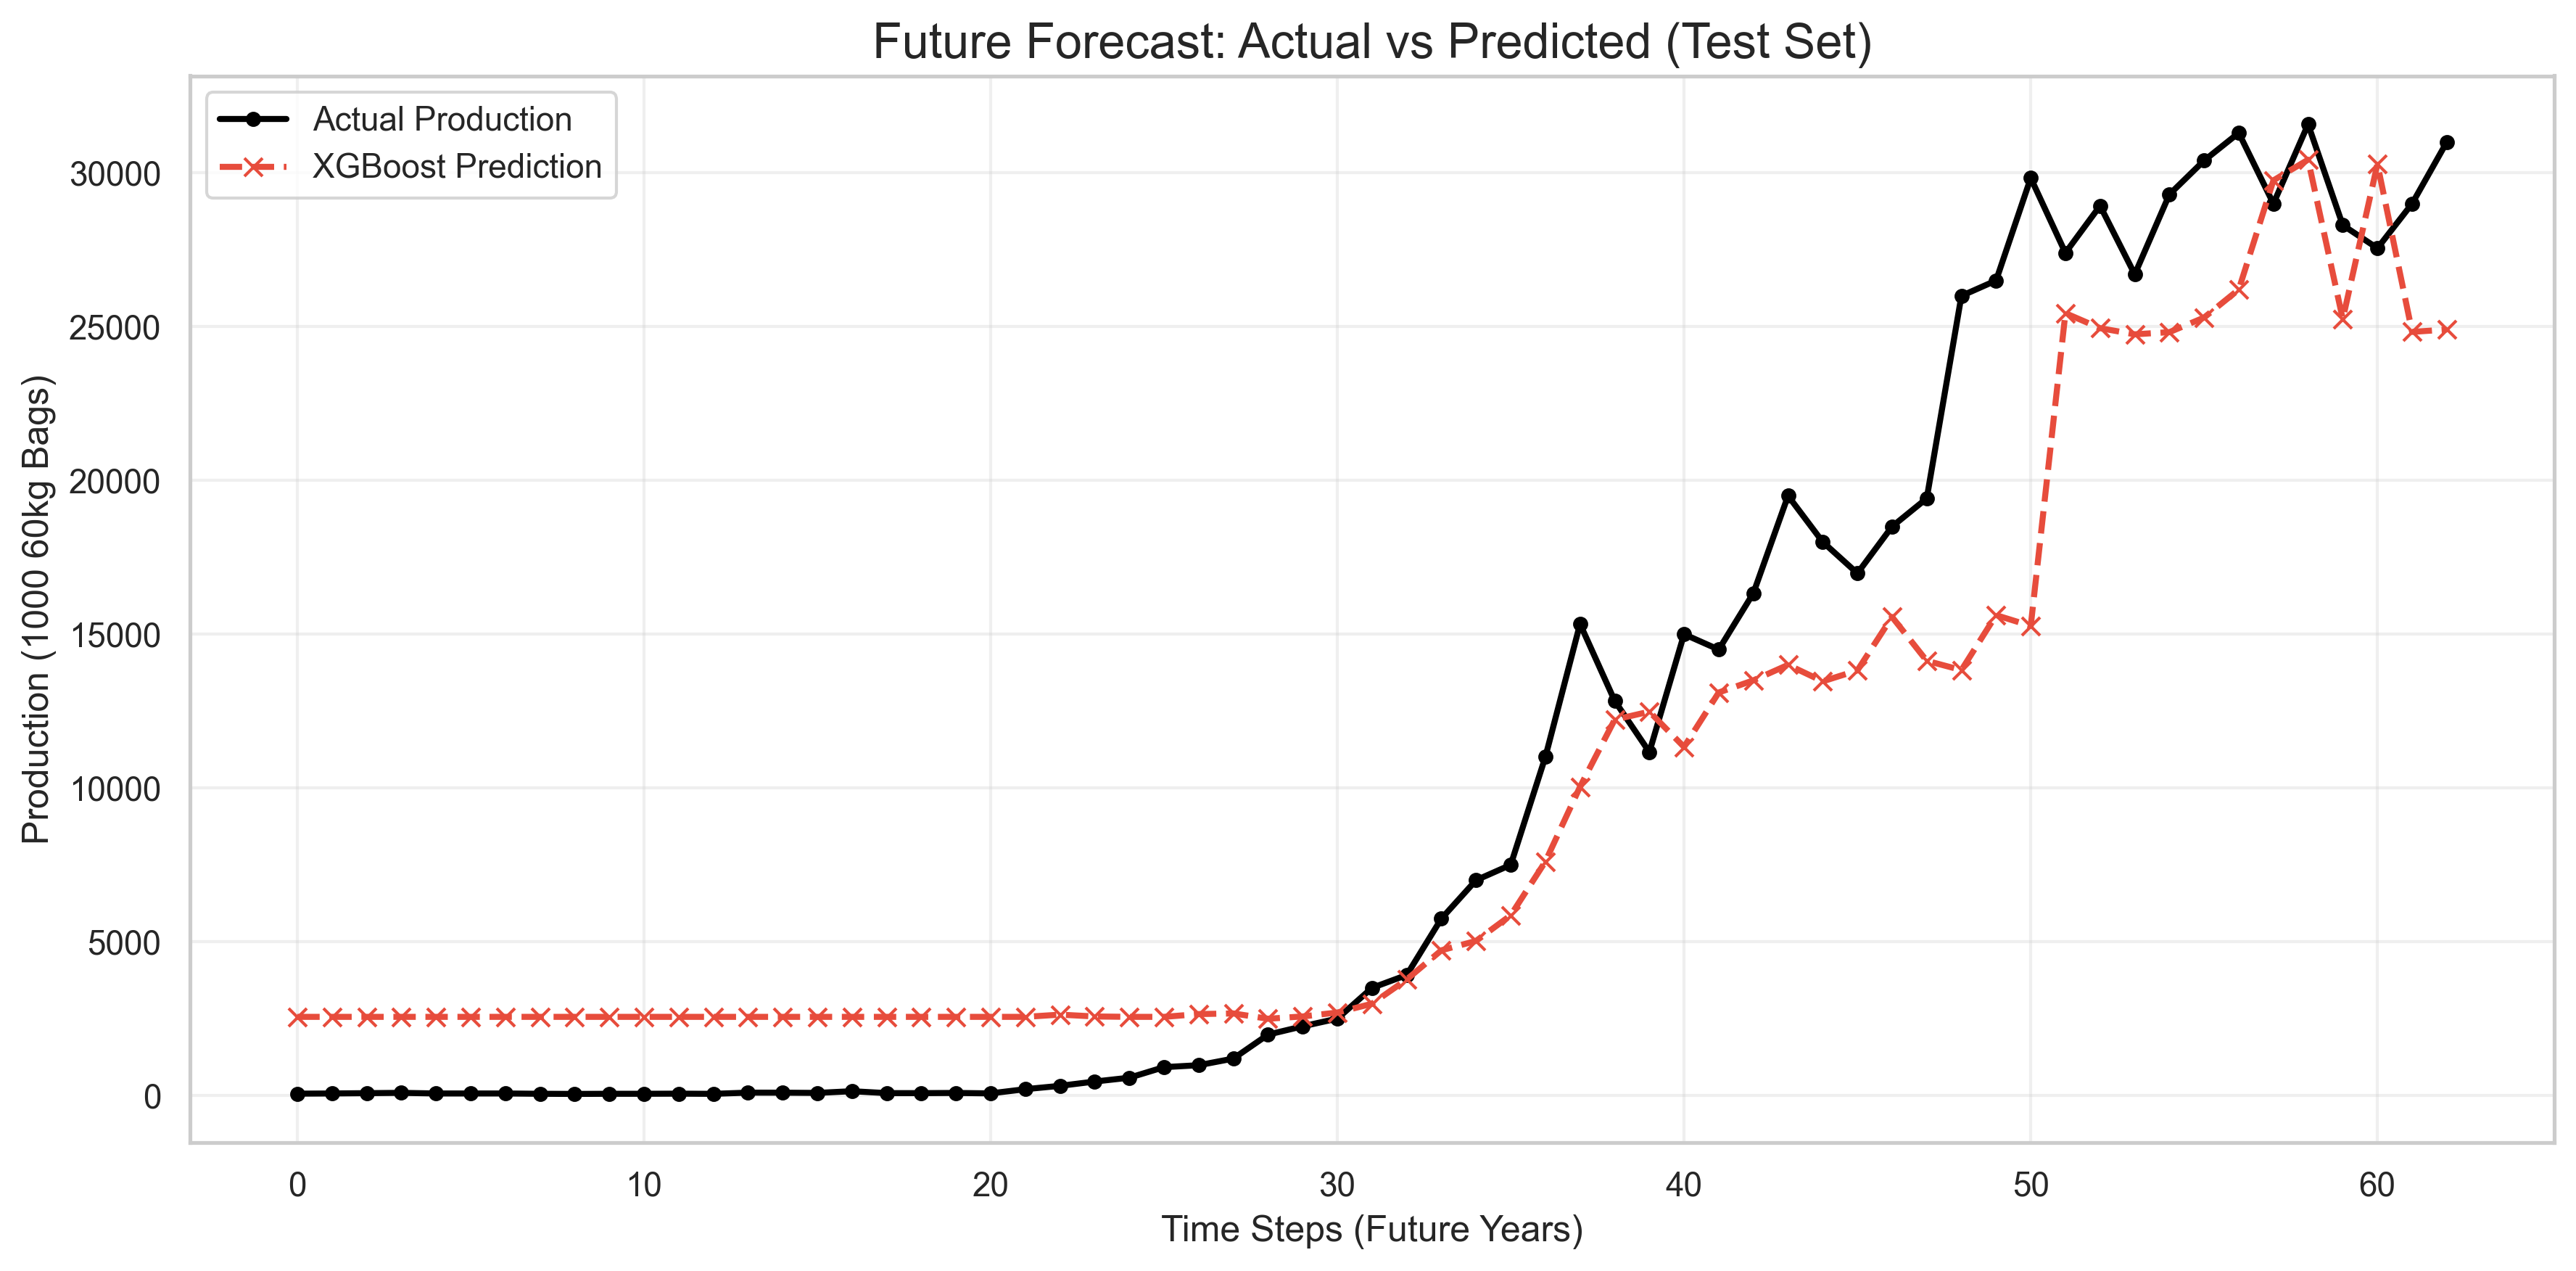


Calculating SHAP Values using KernelExplainer (Universal Method)...
Running KernelExplainer... (This allows robust handling of XGBoost versions)


  0%|          | 0/63 [00:00<?, ?it/s]

Saved SHAP Plot to: ../figures/shap_summary.png


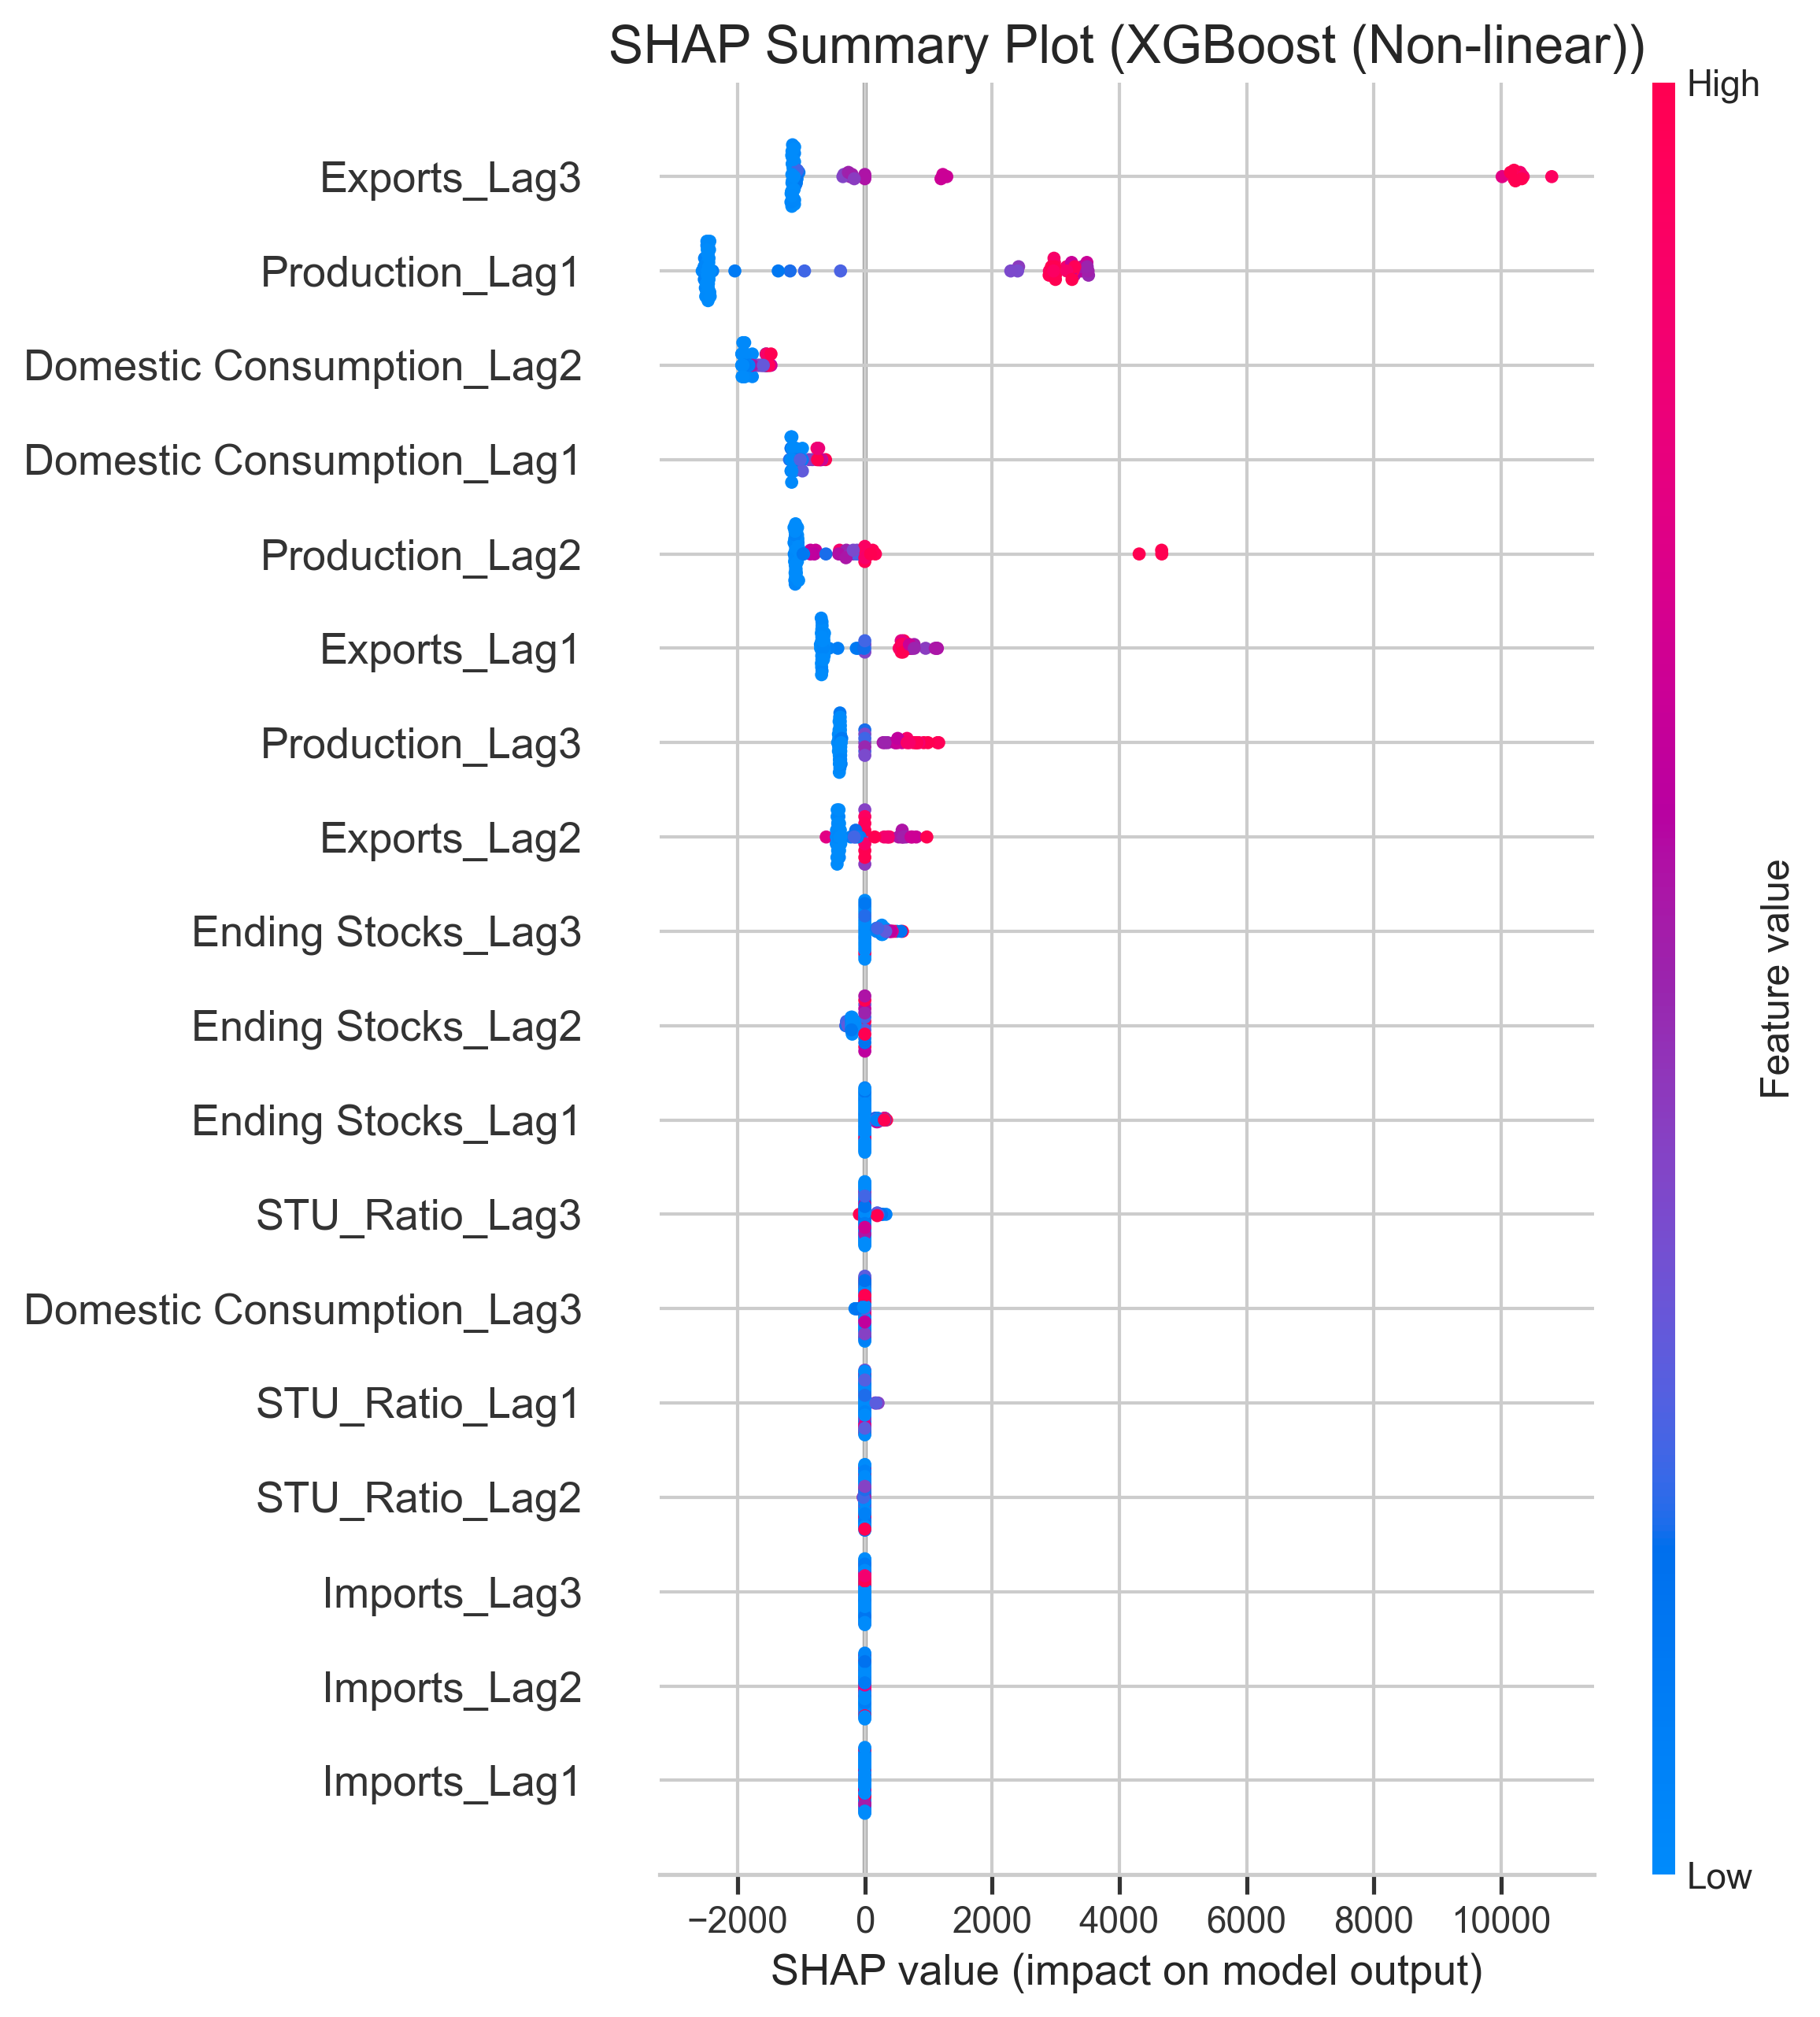


All visualization tasks complete!


In [14]:
# ==========================================
# 7. Visualization & Interpretation (Results Section)
# ==========================================
# Rubric: "Summarize performance... using a figure"
# Rubric: "Calculate SHAP values for local feature importance"

print("--- Phase 7: Final Visualization & Interpretation ---")

import shap
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# Part A: Retrain Model & Plot Predictions (Defines 'viz_pipeline')
# -------------------------------------------------------

# 1. Define the split (80% Train, 20% Test)
split_point = int(len(X) * 0.8)
X_train_viz, X_test_viz = X.iloc[:split_point], X.iloc[split_point:]
y_train_viz, y_test_viz = y.iloc[:split_point], y.iloc[split_point:]

# 2. Retrieve the best model configuration (XGBoost)
# Note: We use the best parameters found in the GridSearch from Cell 7
# (Assumes 'trained_models' and 'model_configs' exist from Cell 7)
best_model_name = 'XGBoost (Non-linear)'
best_pipeline_fitted = trained_models[best_model_name] 
best_params = best_pipeline_fitted.named_steps['model'].get_params()

# 3. Create a FRESH pipeline for visualization
# We do this to ensure clean state and avoid any interference
viz_model = xgb.XGBRegressor(**best_params)
viz_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', viz_model)
])

print(f"Retraining {best_model_name} on first 80% of data...")
viz_pipeline.fit(X_train_viz, y_train_viz)

# 4. Predict & Plot
y_pred_viz = viz_pipeline.predict(X_test_viz)

plt.figure(figsize=(12, 6))
plt.plot(y_test_viz.values, label='Actual Production', color='black', marker='o', markersize=4, linewidth=2)
plt.plot(y_pred_viz, label='XGBoost Prediction', color='#e74c3c', linestyle='--', marker='x', markersize=6, linewidth=2)
plt.title(f'Future Forecast: Actual vs Predicted (Test Set)', fontsize=16)
plt.ylabel('Production (1000 60kg Bags)')
plt.xlabel('Time Steps (Future Years)')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/prediction_vs_actual.png')
print("Saved Prediction Plot to: ../figures/prediction_vs_actual.png")
plt.show()

# -------------------------------------------------------
# Part B: SHAP Values (KernelExplainer - Robust Method)
# -------------------------------------------------------
print("\nCalculating SHAP Values using KernelExplainer (Universal Method)...")

# 1. Prepare Background Data (Required for KernelExplainer)
# We use a small random sample of the training data as reference to speed up calculation
background_data = shap.utils.sample(X_train_viz, 50) 

# 2. Define the Prediction Function
# KernelExplainer needs a function that takes raw data and outputs predictions.
# We wrap our pipeline's predict method.
def model_predict(data_as_array):
    # Convert array back to DataFrame with column names so Pipeline steps work
    data_df = pd.DataFrame(data_as_array, columns=X_train_viz.columns)
    return viz_pipeline.predict(data_df)

# 3. Initialize the Explainer
# link='identity' means we explain the raw output units
explainer = shap.KernelExplainer(model_predict, background_data, link="identity")

# 4. Compute SHAP Values for the Test Set
# nsamples='auto' lets SHAP decide efficient calculation
print("Running KernelExplainer... (This allows robust handling of XGBoost versions)")
# Suppress the progress bar print to keep notebook clean if desired
shap_values = explainer.shap_values(X_test_viz, nsamples='auto')

# 5. Plotting
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_viz, show=False)
plt.title(f"SHAP Summary Plot ({best_model_name})", fontsize=16)
plt.tight_layout()

save_path_shap = '../figures/shap_summary.png'
plt.savefig(save_path_shap)
print(f"Saved SHAP Plot to: {save_path_shap}")
plt.show()

print("\nAll visualization tasks complete!")